In [63]:
# MTF073 Computational Fluid Dynamics
# Task 1: 2D diffusion
# Håkan Nilsson, 2023
# Department of Mechanics and Maritime Sciences
# Division of Fluid Dynamics
# Note that this is not efficient code. It is for educational purposes!

# Clear all variables when running entire code:
from IPython import get_ipython
get_ipython().run_line_magic('reset', '-sf')
# Packages needed
import numpy as np
import matplotlib.pyplot as plt
# Close all plots when running entire code:
plt.close('all')
# Set default font size in plots:
plt.rcParams.update({'font.size': 12})
import os # For saving plots

#===================== Inputs =====================
meshes = [4,8,12,16,20,24,28, 32, 36, 40, 44,48,52,56]
T_vals = []
for i in meshes:
    # Geometric and mesh inputs
    L = 1 # Length of the domain in X direction
    H = 2 # Length of the domain in Y direction  For non-equidistant meshes:
    mI = i # Number of mesh points X direction. 
    mJ = i # Number of mesh points Y direction. 
    mesh_type = 'non-equidistant' # Set 'equidistant' or 'non-equidistant'
    init_T = False

    # Solver inputs

    nIter  =  6000 # set maximum number of iterations
    resTol =  0.001 # set convergence criteria for residuals

    #====================== Code ======================

    # Preparation of "nan", to fill empty slots in consistently numbered arrays.
    # This makes it easier to check in Variable Explorer that values that should
    # never be set are never set (or used). Plots simply omit nan values.
    nan = float("nan")

    # Allocate arrays (nan used to make clear where values need to be set)
    # Note that some arrays could actually be 1D since they only have a variation
    # in one direction, but they are kept 2D so the indexing is similar for all.
    nI = mI + 1                    # Number of nodes in X direction, incl. boundaries
    nJ = mJ + 1                    # Number of nodes in Y direction, incl. boundaries
    pointX = np.zeros((mI,mJ))*nan # X coords of the mesh points
    pointY = np.zeros((mI,mJ))*nan # Y coords of the mesh points
    nodeX  = np.zeros((nI,nJ))*nan # X coords of the nodes
    nodeY  = np.zeros((nI,nJ))*nan # Y coords of the nodes
    dx_PE  = np.zeros((nI,nJ))*nan # X distance to east node
    dx_WP  = np.zeros((nI,nJ))*nan # X distance to west node
    dy_PN  = np.zeros((nI,nJ))*nan # Y distance to north node
    dy_SP  = np.zeros((nI,nJ))*nan # Y distance to south node
    dx_we  = np.zeros((nI,nJ))*nan # X size of the control volume
    dy_sn  = np.zeros((nI,nJ))*nan # Y size of the control volume
    aE     = np.zeros((nI,nJ))*nan # Array for east coefficient, in nodes
    aW     = np.zeros((nI,nJ))*nan # Array for wect coefficient, in nodes
    aN     = np.zeros((nI,nJ))*nan # Array for north coefficient, in nodes
    aS     = np.zeros((nI,nJ))*nan # Array for south coefficient, in nodes
    aP     = np.zeros((nI,nJ))*nan # Array for central coefficient, in nodes
    Su     = np.zeros((nI,nJ))*nan # Array for source term for temperature, in nodes
    Sp     = np.zeros((nI,nJ))*nan # Array for source term for temperature, in nodes
    T      = np.zeros((nI,nJ))*nan # Array for temperature, in nodes
    k      = np.zeros((nI,nJ))*nan # Array for conductivity, in nodes
    k_e    = np.zeros((nI,nJ))*nan # Array for conductivity at east face
    k_w    = np.zeros((nI,nJ))*nan # Array for conductivity at west face
    k_n    = np.zeros((nI,nJ))*nan # Array for conductivity at north face
    k_s    = np.zeros((nI,nJ))*nan # Array for conductivity at south face
    res    = []                    # Array for appending residual each iteration

    # Generate mesh and compute geometric variables

    if mesh_type == 'equidistant':
        # Calculate mesh point coordinates:
        for i in range(0, mI):
            for j in range(0, mJ):
                pointX[i,j] = i*L/(mI - 1)
                pointY[i,j] = j*H/(mJ - 1)
                
    # Smaller to the top and bottom, aka the corners
    #   -------------------------
    #   | | | | | | | | | | | | |
    #   -------------------------
    #   | | |   |   |   |   | | |
    #   | | |   |   |   |   | | |
    #   -------------------------
    #   | | | | | | | | | | | | |
    #   -------------------------

    if mesh_type == 'non-equidistant':
        # Calculate mesh point coordinates with stretching
        stretch = 1.10
        t_stretch = np.tanh(stretch)
        pointX[0,:] = 0
        pointY[:,0] = 0
        for i in range(1, mI):
            z2dp_x = ((2*i+1) - mI)/mI
            pointX[i,:] = (1 + np.tanh(stretch*z2dp_x)/t_stretch) * 0.5 * L
            
        for j in range(1, mJ):
            z2dp_y = ((2*j+1) - mJ)/mJ
            pointY[:,j] = (1 + np.tanh(stretch*z2dp_y)/t_stretch) * 0.5 * H
        pointX[-1,:] = L
        pointY[:,-1] = H

    # Calculate node coordinates (same for equidistant and non-equidistant):
    # Internal nodes:
    for i in range(0, nI):
        for j in range(0, nJ):
            if i > 0 and i < nI-1:
                nodeX[i,j] = 0.5*(pointX[i,0] + pointX[i-1,0])
            if j > 0 and j < nJ-1:
                nodeY[i,j] = 0.5*(pointY[0,j] + pointY[0,j-1])
    # Boundary nodes:
    nodeX[0,:] = 0   # Note: corner points needed for contour plot
    nodeY[:,0] = 0   # Note: corner points needed for contour plot
    nodeX[-1,:] = L  # Note: corner points needed for contour plot
    nodeY[:,-1] = H  # Note: corner points needed for contour plot
    
    # Calculate distances
    # Keep 'nan' where values are not needed!
    for i in range(1, nI-1):
        for j in range(1, nJ-1):
            dx_PE[i,j] = nodeX[i+1,j] - nodeX[i,j]
            dx_WP[i,j] = nodeX[i,j] - nodeX[i-1,j]
            dy_PN[i,j] = nodeY[i,j+1] - nodeY[i,j]
            dy_SP[i,j] = nodeY[i,j] - nodeY[i,j-1]
            dx_we[i,j] = pointX[i,j] - pointX[i-1,j]
            dy_sn[i,j] = pointY[i,j] - pointY[i,j-1]
        
    # Initialize dependent variable array and Dirichlet boundary conditions
    # Note that a value is needed in all nodes for contour plot
    # ADD CODE HERE

    T = np.zeros_like(T)
    T1 = 10
    T2 = 20
    T3 = np.zeros_like(T[:,0])

    T[:,0] = T1
    T[-1,:] = T2
    for i in range(0,nI):
        T3[i] = 5 + 3*(1 + 5*nodeX[i,j]/L)
        T[i,-1] = T3[i]


    if init_T == True:
        T[0,:] = (T1+T2 + np.mean(T3))/3
        for i in range(1,nI-1):
            g_y = np.linspace(T[i,0], T[i,-1],nJ) # linear T on the given x coordinate from the bottom to the top
            for j in range(1,nJ-1):
                g_x = np.linspace(T[0,j], T[-1,j],nI) # linear T on the given y coordinate from the bottom to the top
                T[i,j] = (g_x[i]+g_y[j])/2


    c1 = 25
    c2 = 0.25

    F_vals = []
    F_out_vals = []
    error_vals = []
    certain_T = []
    certain_T_loc = (i//2,i//2)
    for iteration in range(nIter):
        
        # Update conductivity arrays k, k_e, k_w, k_n, k_s, according to your case:
        # (could be moved to before iteration loop if independent of solution,
        # but keep here if you want to easily test different cases)
        # Keep 'nan' where values are not needed!
        # ADD CODE HERE.
        # k for cell midpoint
        for i in range(1,nI-1):
            for j in range(1, nJ-1):
                k[i,j] = 16*(nodeY[i,j]/H + 30*T[i,j]/T1)

        # interpolate to get the surface values for k
        for i in range(1,nI-1):
            for j in range(1,nJ-1):
                k_e[i,j] = k[i,j] + (k[i+1,j] - k[i,j]) * dx_we[i,j]/((dx_we[i,j] + dx_we[i+1,j]))
                k_w[i,j] = k[i,j] + (k[i-1,j] - k[i,j]) * dx_we[i,j]/((dx_we[i,j] + dx_we[i-1,j]))
                k_n[i,j] = k[i,j] + (k[i,j+1] - k[i,j]) * dy_sn[i,j]/((dy_sn[i,j] + dy_sn[i,j+1]))
                k_s[i,j] = k[i,j] + (k[i,j-1] - k[i,j]) * dy_sn[i,j]/((dy_sn[i,j] + dy_sn[i,j-1]))

        # For boundary adjacent nodes
        for i in range(1,nI-1):
            j = 1 # South
            k_s[i,j] = 16*((nodeY[i,j] - dy_sn[i,j]/2)/H + 30*T[i,j]/T1)
            j = -2 # North
            k_n[i,j] = 16*((nodeY[i,j] + dy_sn[i,j]/2)/H + 30*T[i,j]/T1)

        for j in range(1,nJ-1):
            i = 1 # west
            k_w[i,j] = 16*((nodeY[i,j] - dy_sn[i,j]/2)/H + 30*T[i,j]/T1)
            i = -2 # east
            k_e[i,j] = 16*((nodeY[i,j] - dy_sn[i,j]/2)/H + 30*T[i,j]/T1)


        # Update source term array according to your case:
        # (could be moved to before iteration loop if independent of solution,
        # but keep here if you want to easily test different cases)
        # Keep 'nan' where values are not needed!
        for i in range(1,nI-1):
            for j in range(1,nJ-1):
                Sp[i,j] = -15*c2*T[i,j] * dy_sn[i,j] * dx_we[i,j] 
                Su[i,j] = 15*c1 * dy_sn[i,j] * dx_we[i,j]
        
        # Calculate coefficients:
        # (could be moved to before iteration loop if independent of solution)
        # Keep 'nan' where values are not needed!
        # Inner node neighbour coefficients:
        # (not caring about special treatment at boundaries):
        for i in range(1,nI-1):
            for j in range(1,nJ-1):
                Ae = dy_sn[i,j]
                Aw = dy_sn[i,j]
                As = dx_we[i,j]
                An = dx_we[i,j]

                aE[i,j] = Ae*k_e[i,j]/(dx_PE[i,j])
                aW[i,j] = Aw*k_w[i,j]/(dx_WP[i,j])
                aN[i,j] = An*k_n[i,j]/(dy_PN[i,j])
                aS[i,j] = As*k_s[i,j]/(dy_SP[i,j])
        

        # Modifications of aE and aW inside east and west boundaries:
        for j in range(1,nJ-1):
            i = nI-2 #East

            i=1 #West
            # Neumann-boundary condition
            aW[i,j] = 0
        # Modifications of aN and aS inside north and south boundaries:
        for i in range(1,nI-1):
            j = nJ-2 # North

            j=1 # South


        # Inner node central coefficients:
        for i in range(1,nI-1):
            for j in range(1,nJ-1):
                aP[i,j] = aS[i,j] + aN[i,j] + aE[i,j] + aW[i,j] - Sp[i,j]

        # Solve for T using Gauss-Seidel:
        for i in range(1, nI - 1):
            for j in range(1, nJ - 1):
                T[i, j] = ((aW[i, j] * T[i - 1, j] + aE[i, j] * T[i + 1, j] + aS[i, j] * T[i, j - 1] + aN[i, j] * T[i, j + 1] + Su[i, j]) / aP[i, j])

        
        # Copy T to boundaries (and corners) where homegeneous Neumann is applied:
        for j in range(1, nJ - 1):
            i = 0  # West boundary
            T[i, j] = T[i + 1, j]  # dT/dx = 0
        
        # Compute and print residuals (taking into account normalization):
        r = 0
        for i in range(1, nI-1):
            for j in range(1, nJ-1):
                r += abs(aP[i,j]*T[i,j] - (aW[i,j]*T[i-1,j] + aE[i,j]*T[i+1,j] + aN[i,j]*T[i,j+1] + aS[i,j]*T[i,j-1] + Su[i,j]))

        F = 0
        F_out = 0
        dT_dx = np.zeros((nI, nJ))
        dT_dy = np.zeros((nI, nJ))
        # Calculate F_in and F_out from the domain
        for i in range(1,nI-1):
            for j in range(1,nJ-1):
                dT_dx[i, j] = (T[i+1, j] - T[i-1, j]) / (dx_WP[i, j] + dx_PE[i,j])
                dT_dy[i, j] = (T[i, j+1] - T[i, j-1]) / (dy_SP[i, j]+ dy_PN[i,j])
        

        # Add positive source terms to F and negative to F_out
        for i in range(1,nI-1):
            for j in range(1,nJ-1):
                
                if Sp[i,j]*T[i,j] > 0:
                    F += Sp[i,j]*T[i,j]
                else:
                    F_out += Sp[i,j]*T[i,j]

                if Su[i,j] > 0:
                    F += Su[i,j]
                else:
                    F_out += Su[i,j]

        # Compute energy in and out of the DOMAIN, at the borders.
        for i in range(1,nI-1):
            # South boundary
            j = 1
            # interpolate to get the wall temperature gradient
            dT_dy_s = (dT_dy[i, j] -  dT_dy[i, j+1])/dy_PN[i,j] * dy_sn[i,j]/2 + dT_dy[i, j]
            F_s = k_s[i, j] * dx_we[i, j] * dT_dy_s
            if F_s > 0:
                F += F_s
            else:
                F_out += abs(F_s)

            # north boundary
            j = -2
            dT_dy_n = (dT_dy[i, j] -  dT_dy[i, j-1])/dy_SP[i,j] * dy_sn[i,j]/2 + dT_dy[i, j]
            F_n = -k_n[i, j] * dx_we[i, j] * dT_dy_n
            if F_n > 0:
                F += F_n
            else:
                F_out += abs(F_n)

        for j in range(1,nJ-1):
            # West boundary
            # due to neuman boundary, no heat transfer happens at the west boundary
            # i = 1
            # dT_dx_w = 0
            # F_w = k_w[i, j] * dy_sn[i, j] * dT_dx_w
            # if F_w > 0:
            #     F += F_w
            # else:
            #     F_out += F_w
            # East boundary
            i = -2
            dT_dx_e = (dT_dx[i, j] -  dT_dx[i-1, j])/dx_WP[i,j] *dx_we[i,j]/2 + dT_dx[i, j]
            F_e = -k_e[i, j] * dy_sn[i, j] * dT_dx_e
            if F_e > 0:
                F += F_e
            else:
                F_out += abs(F_e)

                
        

        r /= F
        error = np.abs(F - F_out) / F * 100
        if iteration%50 == 0:
            print('iteration: %5d, res = %.5e' % (iteration, r))
            print('Conservation of energy error: %.2f%%' % error, '\n')

        
        # Append residual at present iteration to list of all residuals, for plotting:
        certain_T.append(T[certain_T_loc])
        error_vals.append(error)
        res.append(r)
        F_vals.append(F)
        F_out_vals.append(F_out)
        
        # Stop iterations if converged:
        if r < resTol:
            print('iteration: %5d, res = %.5e' % (iteration, r))
            print('Conservation of energy error: %.2f%%' % error, '\n')
            break

    T_vals.append(certain_T)


iteration:     0, res = 1.72306e+00
Conservation of energy error: 24.70% 

iteration:    13, res = 5.87647e-04
Conservation of energy error: 13.41% 

iteration:     0, res = 4.43263e+00
Conservation of energy error: 220.68% 

iteration:    50, res = 1.67141e-02
Conservation of energy error: 6.47% 

iteration:    78, res = 9.92645e-04
Conservation of energy error: 4.89% 

iteration:     0, res = 7.30172e+00
Conservation of energy error: 512.52% 

iteration:    50, res = 3.34999e-01
Conservation of energy error: 35.12% 

iteration:   100, res = 4.37815e-02
Conservation of energy error: 6.01% 

iteration:   150, res = 6.42451e-03
Conservation of energy error: 2.28% 

iteration:   199, res = 9.94906e-04
Conservation of energy error: 1.74% 

iteration:     0, res = 1.02169e+01
Conservation of energy error: 816.65% 

iteration:    50, res = 9.16036e-01
Conservation of energy error: 91.94% 

iteration:   100, res = 2.60981e-01
Conservation of energy error: 26.52% 

iteration:   150, res = 9.0

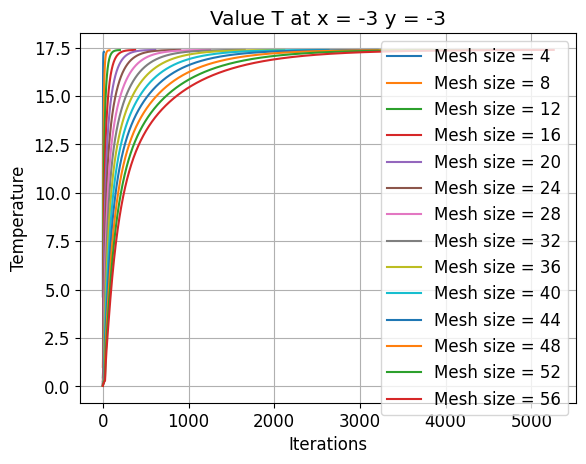

In [64]:
# Plot residual convergence
plt.figure()
plt.title('Value T at x = -3 y = -3')
plt.xlabel('Iterations')
plt.ylabel('Temperature')
resLength = np.arange(0,len(T_vals[-1]),1)
for t in range(len(T_vals)):
    plt.plot(T_vals[t], label = 'Mesh size = ' + str(meshes[t]))

# plt.xscale('log')
plt.legend()
plt.grid()

# if mesh_type == 'equidistant':
#     plt.savefig('Figures/equidistant/Certain_T.png')
# if mesh_type == 'non-equidistant':
#     plt.savefig('Figures/non_equidistant/Certain_T.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


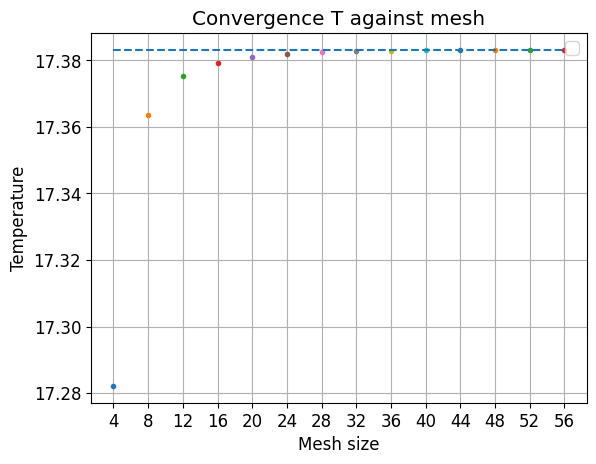

In [67]:
plt.figure()
plt.title('Convergence T against mesh')
plt.xlabel('Mesh size')
plt.ylabel('Temperature')
resLength = np.arange(0,len(T_vals[-1]),1)
for t in range(len(T_vals)):
    plt.plot(meshes[t],T_vals[t][-1],'.')

# plt.xscale('log')
plt.hlines(T_vals[-1][-1],4,56,linestyles='dashed')
plt.xticks(meshes)
plt.legend()
plt.grid()
plt.savefig('mesh_convergence.png')